In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

In [3]:
def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)

In [4]:
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model


In [5]:
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [6]:
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0

In [7]:
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)

In [8]:
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 2
N = 4
M = 20000

In [9]:
def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    ## Normalize the stock prices
    normalizer = np.mean(stock_paths[:, N])
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = create_shallow_NN(1, no_hidden_units)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(0.001))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    ## Train the model  
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 1)
    
    # Test the model
    y_hat_val = model.predict(X_train)
    plt.scatter(X_train, y_train, label='Actual')
    # Sort X_train and y_hat for a smoother line plot
    sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
    X_train_sorted = X_train[sorted_indices]
    y_hat_sorted = y_hat_val[sorted_indices]
    plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
    plt.show()
    
    ## Get the weights of the model
    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)             # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    ## Calculate the option price at the previous monitoring dates
    
    for i in range(N-1, 0, -1):
        normalizer = np.mean(stock_paths[:, i])
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose =0)
        
        # compute the continuation value
        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append(model.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
        
    return option_price[0,0], weights

    
    

Epoch 1/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 43.0151 - val_loss: 40.9244
Epoch 2/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.2899 - val_loss: 40.8484
Epoch 3/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.8452 - val_loss: 40.7720
Epoch 4/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.6659 - val_loss: 40.6922
Epoch 5/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.8752 - val_loss: 40.6088
Epoch 6/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.0624 - val_loss: 40.5213
Epoch 7/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.3265 - val_loss: 40.4297
Epoch 8/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.1480 - val_loss: 40.3339
Epoch 9/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.5935 - val_loss: 40.2342
Epoch 10/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.9312 - val_loss: 40.1292
Epoch 11/3000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.5167 - val_loss: 40.0202
Epoch 12/3000
10/10 ━━━━━━━━━

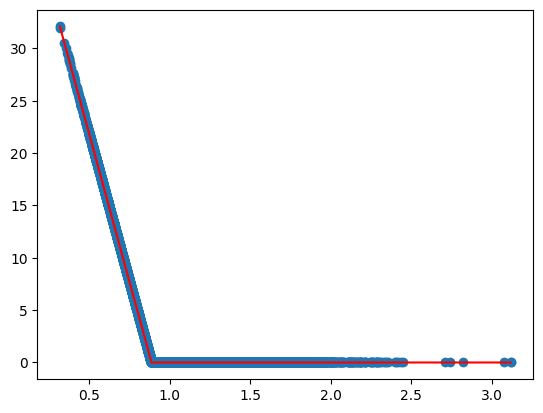

In [10]:
option_price, weights = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', 4)